## Fit 3D Variogram Functions

The 3D Gaussian variogram function has the following form:

$\gamma = s(1 - e^{-3h^{\top} \Omega h} + 0.06e^{-7.07h^{\top} \Omega h})$

where $\Omega$ is a diagonal matrix with diagonal terms $= [\frac{1}{{r_{lon}}^2}, \frac{1}{{r_{lat}}^2}, \frac{1}{{r_{time}}^2}]$

In [22]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.variogram.VariogramFitting import VariogramFitting
import pandas as pd
import os

# read in 2D/3D variogram data
save_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_tuned"
file_name = "tuned_2d_forecast_variogram_area1_edited.npy"
file_path = os.path.join(save_dir, file_name)
data = pd.read_csv(file_path)
data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,space_lag,t_lag,u_semivariance,v_semivariance,detrend_u,detrend_v
0,30,5,0.415299,0.375616,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
1,30,10,0.623212,0.640980,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
2,30,15,0.674698,0.707168,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
3,30,20,0.674506,0.713693,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
4,30,25,0.618187,0.616742,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
...,...,...,...,...,...,...
1595,480,480,1.108294,1.038632,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
1596,480,485,1.090529,1.035751,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
1597,480,490,1.095037,1.042641,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"
1598,480,495,1.111495,1.034401,"[-0.0446293197270464, 0.17572066038165515]","[-0.06611381479194962, 0.14546674762967093]"


In [48]:
fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="u_semivariance")
# list of optimization algorithms: https://lmfit.github.io/lmfit-py/fitting.html
fitted_v.fit_model(4, method="emcee", constrain_weighting=True)  # emcee, leastsq, leastsquare

Number of models: 4
Type of model: gaussian_2d


100%|██████████| 1000/1000 [00:21<00:00, 46.72it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [100.93181613 104.59463144 100.1535256  100.70101191  99.54416698
 107.1641517  108.37487411  93.82893038 104.06939387 102.89740917
 101.54603175]
Parameters:
 [[  0.14886945 126.98611976 100.54208331]
 [  0.19113649  50.4802722  124.3676519 ]
 [  0.19870237  56.92980514  40.12187859]
 [  0.46129168  41.63601837  87.19411901]]


[[  0.24827429  75.43680966 112.95285044]
 [  0.25621657  68.49199822  64.68010933]
 [  0.1470404   84.00229741  77.70962468]
 [  0.34846874  94.07044394  58.99911711]]


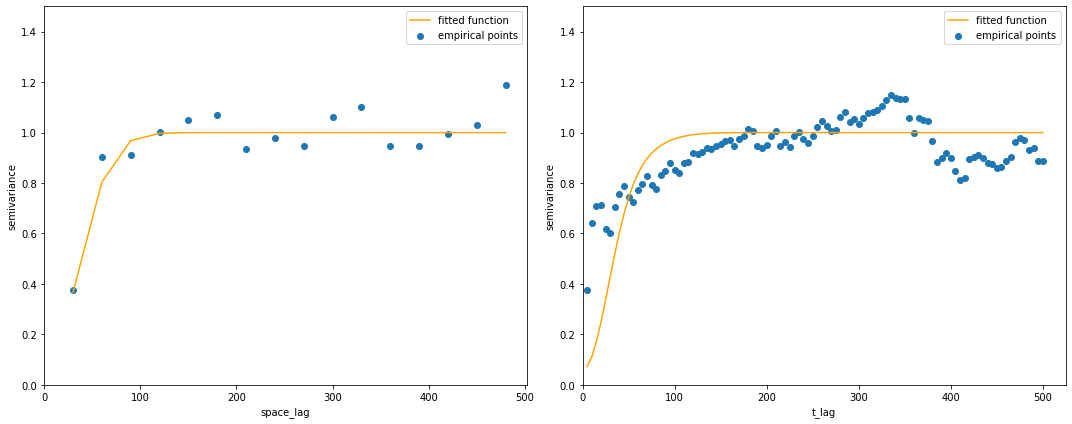

In [9]:
save_path = f"/home/jonas/Downloads/plots/fitted_func_only_cross_buoy.png"
figure = fitted_v.plot_all_dims(save_path=None)
print(fitted_v.popt)

In [50]:
# save parameters
save_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_params"
fitted_v.save_params(os.path.join(save_dir, file_name))

Saved {'U_COMP': [array([  0.14886945, 126.98611976, 126.98611976, 100.54208331]), array([  0.19113649,  50.4802722 ,  50.4802722 , 124.3676519 ]), array([ 0.19870237, 56.92980514, 56.92980514, 40.12187859]), array([ 0.46129168, 41.63601837, 41.63601837, 87.19411901])], 'V_COMP': [array([  0.24827429,  75.43680966,  75.43680966, 112.95285044]), array([ 0.25621657, 68.49199822, 68.49199822, 64.68010933]), array([ 0.1470404 , 84.00229741, 84.00229741, 77.70962468]), array([ 0.34846874, 94.07044394, 94.07044394, 58.99911711])], 'detrend_metrics': [[-0.0446293197270464, 0.17572066038165515], [-0.06611381479194962, 0.14546674762967093]]}


## Plot model from parameters

Number of models: 4
Type of model: gaussian_2d
[[  0.14886945 126.98611976 100.54208331]
 [  0.19113649  50.4802722  124.3676519 ]
 [  0.19870237  56.92980514  40.12187859]
 [  0.46129168  41.63601837  87.19411901]]


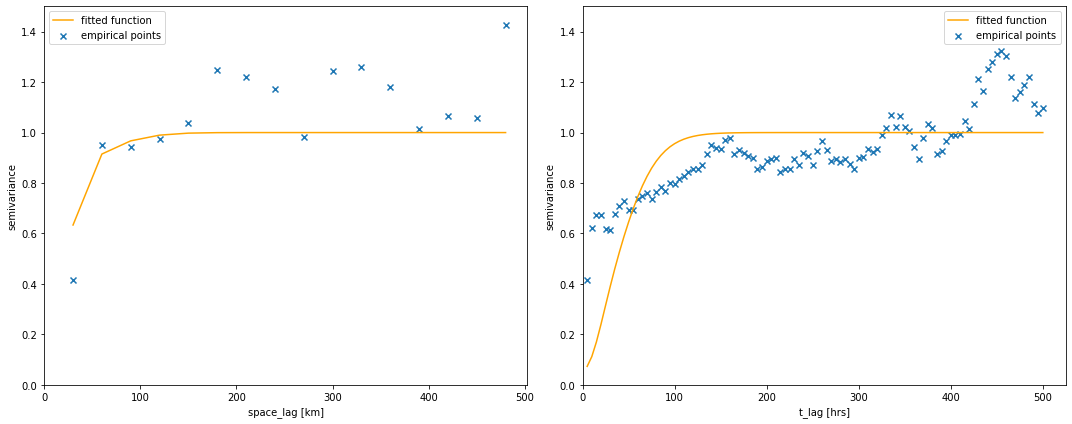

In [23]:
fitted_v = VariogramFitting(data, ("space_lag", "t_lag"), error_var="u_semivariance")
fitted_v.load_params("/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/variogram_params/tuned_2d_forecast_variogram_area1_edited.npy")
_, axs = fitted_v.plot_all_dims(plot_empirical=True)
print(fitted_v.popt)


# import xarray as xr
# import itertools
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
#
# from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
# from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram
#
#
# synthetic_data = xr.load_dataset("/home/jonas/Downloads/test_noise.nc")
# # data = xr.load_dataset("/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/sampled_noise.nc")
# lon_len = len(synthetic_data["lon"].values)
# lat_len = len(synthetic_data["lat"].values)
# time_len = len(synthetic_data["time"].values)
# total_len = lon_len * lat_len * time_len
#
# idx = np.random.choice(list(range(total_len)), size=30000)
#
# lon = synthetic_data["lon"].values.reshape(-1)
# lat = synthetic_data["lat"].values.reshape(-1)
# time = synthetic_data["time"].values.reshape(-1)
#
# axes = np.array(list(itertools.product(time, lat, lon)))[idx]
# time = axes[:, 0]
# lat = axes[:, 1]
# lon = axes[:, 2]
# u_error = synthetic_data["water_u"].values.reshape(-1)[idx]
# v_error = synthetic_data["water_v"].values.reshape(-1)[idx]
#
# synthetic_data = pd.DataFrame({"lon": lon,
#                      "lat": lat,
#                      "time": time,
#                      "u_error": u_error,
#                      "v_error": v_error})
#
# time_plot = np.array(time, dtype=np.int64)
#
# # calculate variogram
# v = Variogram(synthetic_data)
# v.detrend()
# bins, bins_count = v.build_variogram((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)
#
#
# # plot variogram on shared axes
# vvis = VisualizeVariogram(variogram=v)
# vvis.decrease_variogram_res((10, 10))
# view_range = [500, 500]
# vvis.plot_variograms(error_variable="v", label="synthetic points", view_range=view_range, axs_external=axs)
# plt.legend()

In [52]:
import plotly.graph_objects as go
from ocean_navigation_simulator.generative_error_model.variogram.VariogramFitting import gaussian_2d
import numpy as np
import itertools

params = fitted_v.popt
space = np.array(np.arange(0, 300, 10))
time = np.array(np.arange(0, 300, 10))
axes = np.array(list(itertools.product(space, repeat=2)))
print(axes.shape)

query = axes
output = np.zeros(query.shape[0])
for component_model in range(params.shape[0]):
    output += gaussian_2d(query, *params[component_model])
output = output.reshape((space.shape[0], -1))

fig = go.Figure(data=[go.Surface(z=output, x=space, y=time)])
fig.update_layout(title="2D Variogram",
                  autosize=True,
                  width=700,
                  height=600,
                  scene = dict(xaxis_title="space",
                               yaxis_title="time",
                               zaxis_title="semivariance")
                  )
fig.show()

(900, 2)
